## Import Libraries and Dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import glob
import random
import time
import cv2

%matplotlib inline

In [2]:
# Raw data
data_map = []
for sub_dir_path in glob.glob("*"):
    if os.path.isdir(sub_dir_path):
        dirname = sub_dir_path.split("/")[-1]
        for filename in os.listdir(sub_dir_path):
            image_path = sub_dir_path + "/" + filename
            data_map.extend([dirname, image_path])
    else:
        print("Not a dir:", sub_dir_path)
        
        
df = pd.DataFrame({"dirname" : data_map[::2],
                  "path" : data_map[1::2]})
df.head()                                                        

Not a dir: brain_MRI.ipynb
Not a dir: data.csv
Not a dir: README.md


,dirname,path
0,TCGA_CS_4941_19960909,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif
1,TCGA_CS_4941_19960909,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_10...
2,TCGA_CS_4941_19960909,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_10...
3,TCGA_CS_4941_19960909,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_11...
4,TCGA_CS_4941_19960909,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_11...


In [3]:
# Get lenths of the image and mask paths for sorting
base_len = len("TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_")
img_len = len("TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif")
mask_len = len("TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_mask.tif")

# Differentiated lengths of the file suffix numbers (and if it contains mask or not)
img_suffix = img_len - base_len
mask_suffix = mask_len - base_len

# print results
print("Base length: " + str(base_len))
print("Img length: " + str(img_suffix))
print("Mask length: " + str(mask_suffix))


Base length: 44
Img length: 5
Mask length: 10


In [4]:
# Masks vs not masks
df_imgs = df[~df['path'].str.contains("mask")]
df_masks = df[df['path'].str.contains("mask")]

# Data sorting
imgs = sorted(df_imgs["path"].values, key=lambda x : int(x[44:-4]))
masks = sorted(df_masks["path"].values, key=lambda x : int(x[44:-9]))

# Sorting check
idx = random.randint(0, len(imgs)-1)
print("Path to img:", imgs[idx], "\nPath to mask:", masks[idx])

Path to img: TCGA_HT_7874_19950902/TCGA_HT_7874_19950902_13.tif 
Path to mask: TCGA_HT_7874_19950902/TCGA_HT_7874_19950902_13_mask.tif


## Preform Data Exploration and Visualization


In [5]:
# Final dataframe
df = pd.DataFrame({"patient": df_imgs.dirname.values,
                        "image_path": imgs,
                        "mask_path": masks})

df.head()

,patient,image_path,mask_path
0,TCGA_CS_4941_19960909,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...
1,TCGA_CS_4941_19960909,TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_1.tif,TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_1_...
2,TCGA_CS_4941_19960909,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...
3,TCGA_CS_4941_19960909,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...
4,TCGA_CS_4941_19960909,TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_1.tif,TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_1_...


In [6]:
# Adding column for diagnosis
def diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0 : return 1
    else: return 0

df["diagnosis"] = df["mask_path"].apply(lambda x: diagnosis(x))
df.head()

,patient,image_path,mask_path,diagnosis
0,TCGA_CS_4941_19960909,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...,0
1,TCGA_CS_4941_19960909,TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_1.tif,TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_1_...,0
2,TCGA_CS_4941_19960909,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...,0
3,TCGA_CS_4941_19960909,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...,0
4,TCGA_CS_4941_19960909,TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_1.tif,TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_1_...,0


In [7]:
df.value_counts("diagnosis")

diagnosis
0    2556
1    1373
dtype: int64

In [8]:
# Use plotly to plot interactive bar chart
import plotly.graph_objects as go

fig = go.Figure([go.Bar(
    x = df['diagnosis'].value_counts().index, 
    y = df['diagnosis'].value_counts(),
    )])

fig.update_traces(marker_color = 'rgb(254,127,156)', marker_line_color = 'rgb(231,84,128)',
                  marker_line_width = 6, opacity = 0.7)

fig.update_xaxes(
    tickvals=[0, 1],
    ticktext=["Negative", "Positive"]
)

fig.update_layout(
    title='Diagnosis Distribution',
    xaxis=dict(title='Diagnosis'),
    yaxis=dict(title='Total Images'),
)
fig.show()

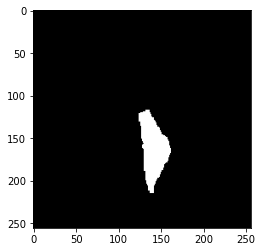

In [9]:
#df[df["diagnosis"] == 1].sample(1).image_path.index # 2751
plt.imshow(cv2.imread(df.mask_path[2751]))

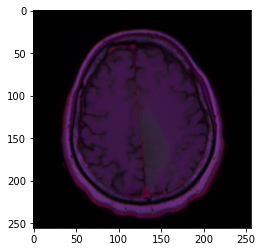

In [10]:
plt.imshow(cv2.imread(df.image_path[2751]))

In [11]:
# Check pixel values
cv2.imread(df.mask_path[2751]).max()

255

In [12]:
# Check pixel values
cv2.imread(df.mask_path[2751]).min()

0

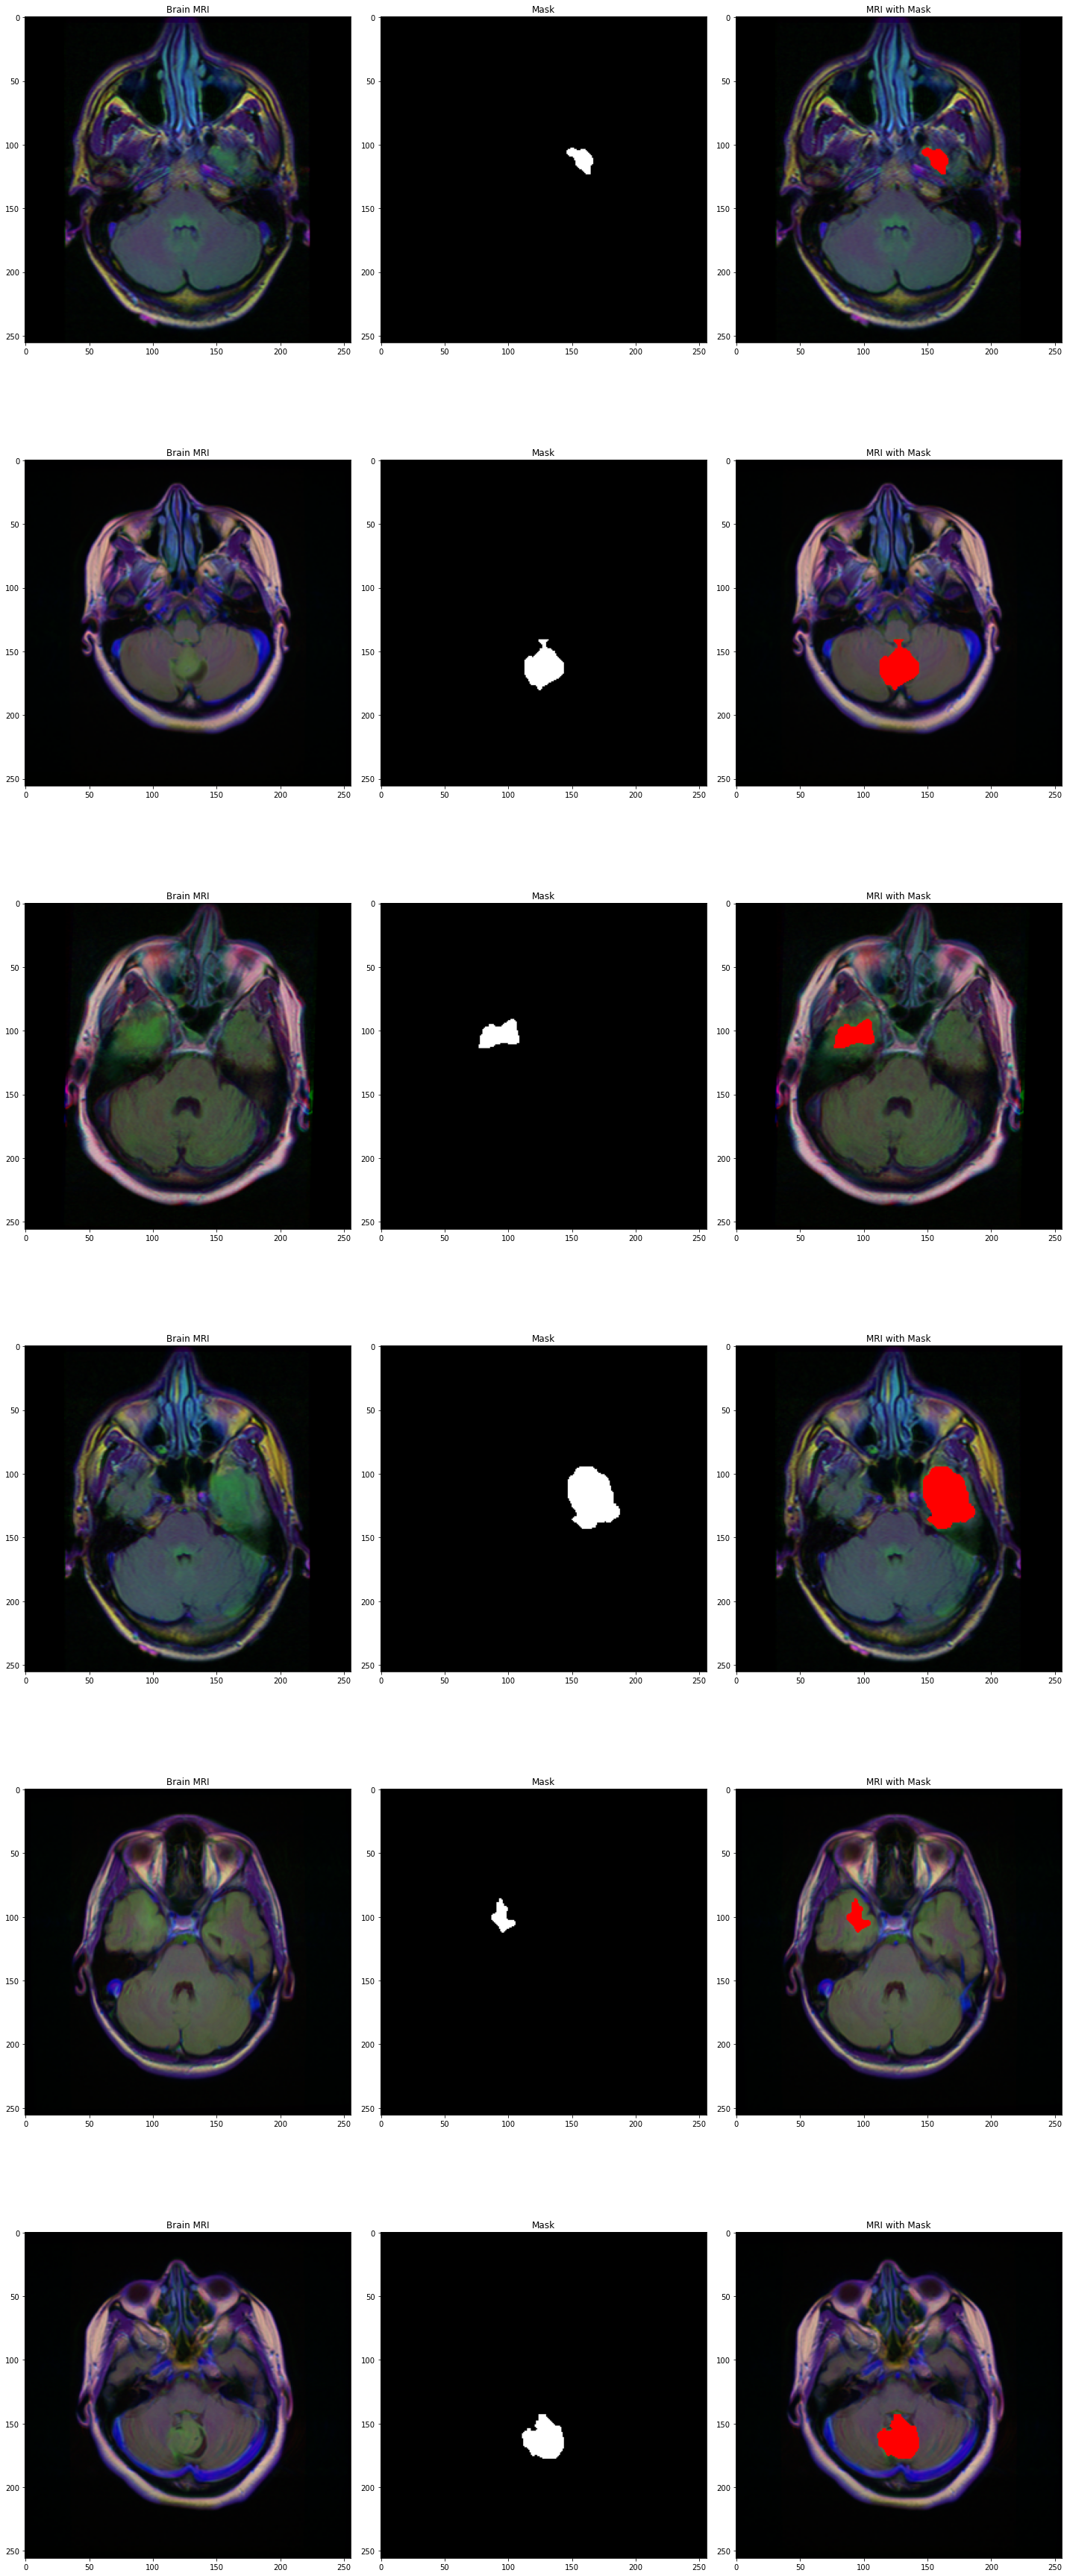

In [13]:
# Show the images and masks and highlight the masks
from skimage import io
count = 0
fig, axs = plt.subplots(6, 3, figsize = (20, 50))
for i in range(len(df)):
  if df['diagnosis'][i] ==1 and count <6:
    img = io.imread(df.image_path[i])
    axs[count][0].title.set_text('Brain MRI')
    axs[count][0].imshow(img)

    # Load the mask
    mask = io.imread(df.mask_path[i])
    axs[count][1].title.set_text('Mask')
    axs[count][1].imshow(mask, cmap = 'gray')

    # Replace the mask pixels with the color red
    img[mask == 255] = (255, 0, 0)
    axs[count][2].title.set_text('MRI with Mask')
    axs[count][2].imshow(img)
    count+=1

fig.tight_layout()

## Train a Classifier Model to Detect if a Tumor is Present

In [14]:
# Importing more libraries
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize

In [15]:
# Drop patient id column not needed for training
df_train = df.drop(columns = ['patient'])
df_train.head()

,image_path,mask_path,diagnosis
0,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...,0
1,TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_1.tif,TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_1_...,0
2,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...,0
3,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...,0
4,TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_1.tif,TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_1_...,0


In [16]:
# Convert diagnosis column to string to use categorically
df_train['diagnosis'] = df_train['diagnosis'].apply(lambda x: str(x))


In [17]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   diagnosis   3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


In [18]:
# Split the data into training and validation sets
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_train, test_size = 0.15)

In [19]:
# Create an image generator
from keras_preprocessing.image import ImageDataGenerator

# Create a data generator
data_gen = ImageDataGenerator(rescale = 1./255., validation_split = 0.15)